<h1>Getting started with TensorFlow</h1>
<p>The following notebook assumes limited to no knowledge of TensorFlow, but it will require basic Python literacy and for the TensorFlow, Numpy, and Matplotlib modules to be installed (They should be unless you maliciously uninstalled them.)</p>

In [ ]:
import tensorflow as tf
import numpy as np

<h2>Lesson Goals:</h2>
<ol>
    <li>Understanding Machine Learning Models as Function Approximators.</li>
    <li>Defining ML Models in TensorFlow.</li>
    <li>Training ML Models.</li>
</ol>
<a name="FunctionApproximator"></a>
<h3>Understanding Machine Learning Models as Function Approximators</h3>
<p>In general, most ML models are made with a very simple purpose: to produce 'intelligent' output for a given problem. This is an over simplified way of thinking of things, but it reveals some of our key goals: we want to make a model which produces output we like based on a set of input(s). In this sense, we can imagine our ML model as a universal function approximator: something which mimics the output we would like given a set of examples. For this lesson, we will start by loading a set of data and making a model which can accurately predict values for our unknown function.</p>
<h3>Loading the data</h3>
<p>We begin by using Python's pickle module to load the binary data file containing our unknown function's input and output examples.</p>

In [ ]:
import pickle
file_name = 'data.p'
data = None
with open(file_name, 'rb') as out_file:
    data = pickle.load(out_file)
if data is not None:
    print('Loaded data from {}.\nData:{}'.format(file_name, data))

<p>The previous code should print out the data for our inputs and outputs, but it would probably be helpful to display the data on a graph so we can get a better idea of what kind of function we are trying to model. The following code plots our data as a series of red points.</p>

In [ ]:
import matplotlib.pyplot as plt
plt.plot(data['inputs'], data['outputs'], 'ro')
plt.show()

<p>Since we have a set of input/output examples showing the expected output of our model, we could classify this ML problem as a <i>supervised learning</i> problem. In this case, we know that the output of our model should closely match that of the graph above. In order to determine which models we use to approximate this function are better, we will need to define a loss function to quantify how far off our model is. For continuous, regression type problems like this, a common loss function is to average the squares of the differences between the true value (denoted $y$) and the approximated value (denoted $\hat{y}$).</p>
$$loss=\frac{1}{n}\sum_0^n{(y_i-\hat{y_i})^2}$$
<p>This is often referred to as the Mean Squared Error (MSE).</p>

In [ ]:
def MSE(ys,ys_approx):
    loss = 0
    for y, y_approx in zip(ys, ys_approx):
        loss += (y - y_approx) ** 2
    return loss/len(ys)

<h3>Linear Approximation</h3>
<p>We can try simply approximating our model using the slope-intercept formula:</p>
$$y = m*x + b$$
<p>Try to find best line of fit possible (lowest loss). Do not spend more than 5 minutes on this portion.</p>

In [ ]:
m = 0.339 #-1 #0.339
b = -5 #3 #-5

y = lambda x: m * x + b
print('Loss for function approximation: ', MSE(data['outputs'], y(data['inputs'])))

plt.plot(data['inputs'], y(data['inputs']), 'b-')
plt.plot(data['inputs'], data['outputs'], 'ro')
plt.show()

<p>We may  have managed to find a line which works, but in practice, we do not want to have to figure out the ideal values for $m$ or $b$. This is what we have ML and gradient descent for. Next, we will set up a simple linear approximator which we will train with TensorFlow. The following code begins by resetting the TensorFlow graph. This is typically run before creating your networks to ensure that there are no duplicate tensors. Afterwards, we define a placeholder for our X input(s). Placeholders allow us to fill in their places later with our data set for training the model.</p>

In [ ]:
tf.reset_default_graph()
XS = tf.placeholder(tf.float32, shape=[None, 1], name='Xs')
#TO-DO: Define a placeholder for our expected output: TrueYS
YS = tf.placeholder(tf.float32, shape = [None, 1], name = 'YS')

M = tf.Variable(0.339, dtype=tf.float32, name='Slope')
#TO-DO: Define a variable for bias: B
B = tf.Variable(-5, dtype = tf.float32, name = 'Intercept')

#Our TensorFlow Linear Approximator: YApprox
YApprox = M * XS + B

<p>With this taken care of, we can initialize and run our model with the following code. Note that whenever we want to access the output of a TensorFlow operation, we use 'sess.run()' to obtain the output of the operation. Additionally, we need to specify what takes the place of our XS placeholder in a dictionary.</p>

In [ ]:
#Start a new TF session to run our model
with tf.Session() as sess:
    #Initialize our variables
    sess.run(tf.global_variables_initializer())
    #Determine our outputs for the given data inputs:
    y_approx = sess.run(YApprox, {XS : np.transpose([data['inputs']])})
    print('Loss for function approximation: ', MSE(data['outputs'], y_approx))
    

plt.plot(data['inputs'], y_approx, 'b-')
plt.plot(data['inputs'], data['outputs'], 'ro')
plt.show()

<p>Now that we have defined our simple linear approximator, lets try to train it against the data to figure out the best values for $m$ and $b$. We do this by defining a loss function which compares our model's prediction to the true value for $y$. Running this code should produce nearly the same estimated loss as our MSE function:</p>

In [ ]:
loss = tf.losses.mean_squared_error(YS, YApprox)
with tf.Session() as sess:
    #Initialize our variables
    sess.run(tf.global_variables_initializer())
    #Compute our losses
    losses = sess.run(loss, {
        XS : np.transpose([data['inputs']]),
        YS : np.transpose([data['outputs']])})
    print('Loss for function approximation:', losses)

<p>Now that we can user TensorFlow to calculate the losses of our model, we will try to train our model to minimize this loss function and find the ideal values of $m$ and $b$. We begin by defining our Gradient Descent Optimizer, which will be used to determine how to change our variables. From there, we define our train operation as using our optimizer to minimize our function approximator's loss. Once this is taken care of, we simply need to train the agent with the data we have to work with.</p>

In [ ]:
for key in data:
    print(key)
    print(data[key])

In [ ]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss)
training_epochs =  8
with tf.Session() as sess:
    #Initialize our variables
    sess.run(tf.global_variables_initializer())
    for epoch in range(training_epochs):
        feed_dict = {
            XS : np.transpose([data['inputs']]),
            YS : np.transpose([data['outputs']])
        }
        losses, m, b, _ = sess.run([loss, M, B, train_op], feed_dict)
        print('Loss after {} epochs: {}'.format(epoch+1, losses))
        print('y = {} * x + {}\n'.format(m, b))
        plt.plot(data['inputs'], y(data['inputs']), label='Epoch {}'.format(epoch))
    plt.plot(data['inputs'], data['outputs'], 'ro')
    plt.legend()
    plt.show()

<p>Try messing with the learning_rate and training_epochs variables to train the line to better fit the data.</p>

<h3>Nonlinear layers?</h3>
<p>Even if we trained our model perfectly, it still falls short of accurately modeling our data. This is because our data and the function we are trying to approximate is not linear. In order to make our ML model more accurate, we will use Neural Networks with nonlinear transformations/activations.</p>

In [146]:
tf.reset_default_graph()
number_hidden_neurons = 64 #128
XS = tf.placeholder(tf.float32, shape=[None, 1], name='Xs')

inputs = tf.concat([XS, tf.cos(XS), tf.sin(XS)], axis = 1)
print('inputs: ', inputs.shape)

hidden1 = tf.layers.dense(inputs, number_hidden_neurons, activation=tf.nn.relu)
#TO-DO: add additional hidden layers. Try changing the activation functions or number of hidden neurons
hidden2 = tf.layers.dense(hidden1, number_hidden_neurons, activation=tf.nn.relu)
#hidden3 = tf.layers.dense(hidden2, number_hidden_neurons, activation=tf.nn.relu)
#hidden4 = tf.layers.dense(hidden3, number_hidden_neurons, activation=tf.nn.tanh)
#hidden5 = tf.layers.dense(hidden4, number_hidden_neurons, activation=tf.nn.tanh)


YApprox = tf.layers.dense(hidden2, 1)
YS = tf.placeholder(tf.float32, shape=[None, 1], name='TrueYs')
loss = tf.losses.mean_squared_error(YS, YApprox)

inputs:  (?, 3)


0 0.0
100 53.772858
200 23.45691
300 58.808136
400 -62.433655
500 114.454254
600 -58.610962
700 -44.63681
800 30.240082
900 83.37669
1000 52.25705
1100 10.522263
1200 -24.964264
1300 21.33139
1400 -0.14001465
1500 20.448746
1600 11.592392
1700 8.491669
1800 12.970413
1900 11.19722
2000 2.892395
2100 4.7577515
2200 12.964455
2300 -2.2660446
2400 10.749336
2500 6.8820114
2600 -1.4172821
2700 6.224167
2800 13.189796
2900 -5.7990646
3000 11.082516
3100 -1.9441986
3200 2.2366524
3300 11.106586
3400 -2.1304932
3500 2.1847534
3600 5.892063
3700 3.037346
3800 -9.771408
3900 11.242119
4000 0.9701958
4100 -5.57304
4200 6.6707077
4300 -1.9600105
4400 14.759075
4500 -7.765808
4600 2.311039
4700 -0.43107033
4800 3.5447617
4900 3.8525429
5000 -3.5102425
5100 -3.3709087
5200 6.154854
5300 -2.6150684
5400 4.380743
5500 -3.5148067
5600 1.4907894
5700 1.9295788
5800 -6.331871
5900 8.15098
6000 -3.245901
6100 3.1260452
6200 3.912878
6300 3.1813602
6400 -3.0046463
6500 2.654045
6600 1.0734539
6700 -0.9377

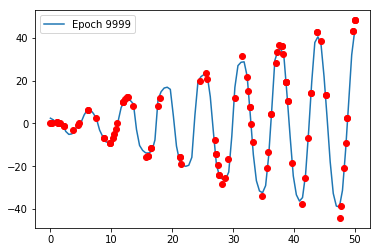

In [149]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001)
train_op = optimizer.minimize(loss)
training_epochs =  10000
#Try changing the number of training epochs
with tf.Session() as sess:
    #Initialize our variables
    sess.run(tf.global_variables_initializer())
    last_loss=None
    for epoch in range(training_epochs):
        feed_dict = {
            XS : np.transpose([data['inputs']]),
            YS : np.transpose([data['outputs']])
        }
        losses, _ = sess.run([loss, train_op], feed_dict)
        if last_loss==None:
            last_loss=losses
        if epoch%100==0:
            print(str(epoch)+" "+str(last_loss-losses))
            last_loss=losses
            
    print('Loss after {} epochs: {}'.format(epoch+1, losses))
    xs = np.transpose([np.linspace(0, max(data['inputs']), 100)])
    ys_approx = sess.run([YApprox], {XS : xs})
    xs = np.transpose(xs)[0]
    ys_approx = np.transpose(ys_approx)[0]
    plt.plot(xs, ys_approx, label='Epoch {}'.format(epoch))
    plt.plot(data['inputs'], data['outputs'], 'ro')
    plt.legend()
    plt.show()

In [142]:
indices = [i for i in range(len(data['inputs']))]
indices = np.random.permutation(indices)
print('Total indicies: ', indices)
train_ratio = 0.8
training_count = int(train_ratio * len(indices))
train_indices = indices[0: int(train_ratio * len(indices))]
print('Train indicies: ', len(train_indices))
test_indices = indices[training_count : ]
print('Test indices: ', len(test_indices))


Total indicies:  [57 23 44 78 76  5 41 86 20  0 83 25 56 54 11 32 92 80 68 65 26 66 84 27
 34 24 12 94  2 53 98 59 99 81 67 72 55 33 93 29 82 85  1 51 52  7 18 37
 75 40 13 60 64 96 10 95 38 28 90 61 35 58  4 87  6 30 16 39 21 70 79  9
 50 63 48 49 42 45 46 22 91 62 77 74 69  8 47 17 19 31 88  3 43 15 97 14
 73 71 36 89]
Train indicies:  80
Test indices:  20


In [ ]:
train_input = data[]